In [1]:
import numpy as np
import pandas as pd
import re,os
import json 
from pathlib import Path
from dirs import TRANSFORMERS_CACHE_DIR, DATA_DIR, LARGE_DATA_DIR
import glob
working_bert="bert_base"
#WORKING_PATH=DATA_DIR+"ridge/3l/"
#WORKING_PATH="/home/PERSONALE/niccolo.barbieri3/thesis_project/thesis_data/l1_saga_basic/fold/3l/"
selected_set="Fut_set"
WORKING_PATH=DATA_DIR+f"logits_results/{working_bert}/"
names_single=["n2v",
             #"leiden",
             #"louvain",
             #"lap",
             "fa2",
             #"lab_prop",
             "norm_lap",
             "norm_leiden",
             "norm_louvain",
             "norm_lab_prop"]
names_comp=[i+"+text" for i in names_single]

In [2]:
def leggi_json(percorso):
    try:
        with open(percorso, "r", encoding="utf-8") as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"Errore: File non trovato - {percorso}")
        return None

In [3]:
percorsi = {
    "neural_network": f"{DATA_DIR}results/my_class_results/alberto/output.json",
    "enet_025": f"{DATA_DIR}results/elasticnet_saga_basic_0.25/fold/3l/output.json",
    "enet_05": f"{DATA_DIR}results/elasticnet_saga_basic_0.5/fold/3l/output.json",
    "enet_075": f"{DATA_DIR}results/elasticnet_saga_basic_0.75/fold/3l/output.json",
    "l1": f"{DATA_DIR}results/l1_saga_basic/fold/3l/output.json",
    "l2": f"{DATA_DIR}results/l2_saga_basic/fold/3l/output.json"
}

# Lettura dei file in un dizionario
dizionari = {chiave: leggi_json(percorso) for chiave, percorso in percorsi.items()}
text=leggi_json(f"{DATA_DIR}text_results/alberto/output.json")
# Estrazione delle metriche (solo se il file esiste e contiene i dati richiesti)
accuracy = {
    chiave: [dizionari[chiave][i]["Val_set"]["accuracy"] for i in names_single]
    if dizionari[chiave] else None
    for chiave in percorsi.keys()
}
table_1=pd.DataFrame(data=accuracy,index=names_single)
table_1

,neural_network,enet_025,enet_05,enet_075,l1,l2
n2v,0.606112,0.630887,0.630466,0.624170,0.625009,0.629207
fa2,0.611565,0.622072,0.619554,0.618715,0.619135,0.622911
norm_lap,0.578002,0.613265,0.613264,0.614102,0.617459,0.613262
norm_leiden,0.598983,0.627948,0.628367,0.629625,0.629206,0.629206
norm_louvain,0.590594,0.624589,0.627106,0.626688,0.625429,0.625010
norm_lab_prop,0.596467,0.594388,0.596484,0.593549,0.597324,0.595228


In [4]:
err_accuracy = {
    chiave: [(dizionari[chiave][i]["Val_set"]["int_conf_accuracy"]["high"]-dizionari[chiave][i]["Val_set"]["int_conf_accuracy"]["low"])/3 for i in names_single]
    if dizionari[chiave] else None
    for chiave in percorsi.keys()
}
err_table_1=pd.DataFrame(data=err_accuracy,index=names_single)
err_table_1

,neural_network,enet_025,enet_05,enet_075,l1,l2
n2v,0.039068,0.014507,0.013473,0.011034,0.011238,0.013310
fa2,0.044392,0.019926,0.018784,0.018449,0.018616,0.020330
norm_lap,0.048113,0.012072,0.011621,0.010055,0.009799,0.010846
norm_leiden,0.036505,0.016958,0.016746,0.017056,0.015337,0.016981
norm_louvain,0.033137,0.013155,0.012312,0.014945,0.014486,0.014931
norm_lab_prop,0.034595,0.012459,0.011505,0.012522,0.014450,0.014139


In [5]:
cartella_base = DATA_DIR+"logits_results"
cartelle_primo_livello = [
    d for d in os.listdir(cartella_base)
    if os.path.isdir(os.path.join(cartella_base, d)) and d != ".ipynb_checkpoints"
]

# Dizionari per salvare i dati
dati_output = {}
dati_weights = {}

# Itera su tutte le cartelle di primo livello
for cartella in cartelle_primo_livello:
    percorso_alberto = os.path.join(cartella_base, cartella, "alberto")  # Percorso alla cartella "alberto"

    if os.path.isdir(percorso_alberto):  # Verifica che "alberto" esista
        # Percorsi ai file JSON
        file_output = os.path.join(percorso_alberto, "output.json")
        file_weights = os.path.join(percorso_alberto, "weights.json")

        # Legge output.json
        if os.path.isfile(file_output):
            with open(file_output, "r", encoding="utf-8") as f:
                dati_output[cartella] = json.load(f)

        # Legge weights.json
        if os.path.isfile(file_weights):
            with open(file_weights, "r", encoding="utf-8") as f:
                dati_weights[cartella] = json.load(f)
renamer = {
    'my_net':"neural_network",
    'elasticnet_saga_basic_0.25': "enet_025",
    'elasticnet_saga_basic_0.5':"enet_05",
    'elasticnet_saga_basic_0.75':"enet_075",
    'l1_saga_basic':"l1",
    'l2_saga_basic':"l2"
}
dati_output={renamer.get(k, k): v for k, v in dati_output.items()}
dati_weights={renamer.get(k, k): v for k, v in dati_weights.items()}

In [6]:
second_table={}
weights={}
models={}
for i in table_1.index:
    second_table[i+"+text"]=dati_output[table_1.loc[i].idxmax()][i+"+text"]["Val_set"]["accuracy"]
    weights[i]=dati_weights[table_1.loc[i].idxmax()][i]
    models[i]=table_1.loc[i].idxmax()
second_table_df=pd.DataFrame(data=[second_table.values(),weights.values(),models.values()],index=["accuracy","weights","model"])
second_table_df=second_table_df.rename(columns={i:list(second_table.keys())[i] for i in range(6)})
second_table_df

,n2v+text,fa2+text,norm_lap+text,norm_leiden+text,norm_louvain+text,norm_lab_prop+text
accuracy,0.705127,0.706799,0.694215,0.696734,0.694636,0.699252
weights,0.601804,0.620806,0.606542,0.664624,0.719424,0.618913
model,enet_025,l2,l1,enet_075,enet_05,l1


In [7]:
second_table_err={}
weights_err={}
models_err={}
for i in table_1.index:
    second_table_err[i+"+text"]=(dati_output[table_1.loc[i].idxmax()][i+"+text"]["Val_set"]["int_conf_accuracy"]["high"]-dati_output[table_1.loc[i].idxmax()][i+"+text"]["Val_set"]["int_conf_accuracy"]["low"])/3
    weights_err[i]=dati_weights[table_1.loc[i].idxmax()][i]
    models_err[i]=table_1.loc[i].idxmax()
second_table_df_err=pd.DataFrame(data=[second_table_err.values(),weights_err.values(),models_err.values()],index=["accuracy","weights","model"])
second_table_df_err=second_table_df_err.rename(columns={i:list(second_table_err.keys())[i] for i in range(6)})
second_table_df_err

,n2v+text,fa2+text,norm_lap+text,norm_leiden+text,norm_louvain+text,norm_lab_prop+text
accuracy,0.03614,0.044852,0.039001,0.029496,0.031456,0.033464
weights,0.601804,0.620806,0.606542,0.664624,0.719424,0.618913
model,enet_025,l2,l1,enet_075,enet_05,l1


In [8]:
dizionari

{'neural_network': {'n2v': {'Train_set': {'accuracy': 0.6081160218504263,
    'int_conf_accuracy': {'low': 0.5945950841284398,
     'high': 0.6216369595724129},
    'f1_score': 0.6081160218504263,
    'int_conf_f1_score': {'low': 0.5945950841284398,
     'high': 0.6216369595724129},
    'f1_scores': [0.674659419123256, 0.10275676740617316, 0.769865122017053],
    'int_conf_f1_scores': [{'low': 0.6612539874919132,
      'high': 0.6880648507545988},
     {'low': 0.01985233601031558, 'high': 0.18566119880203075},
     {'low': 0.7484639188072869, 'high': 0.7912663252268192}],
    'matthews': 0.4533875997472143,
    'int_conf_matthews': {'low': 0.441683607552988,
     'high': 0.4650915919414406}},
   'Val_set': {'accuracy': 0.6061122562232439,
    'int_conf_accuracy': {'low': 0.5475108499185787,
     'high': 0.6647136625279092},
    'f1_score': 0.6061122562232439,
    'int_conf_f1_score': {'low': 0.5475108499185787,
     'high': 0.6647136625279092},
    'f1_scores': [0.6686000801595504, 0.1

In [9]:
best_comb = second_table_df.loc["accuracy"].astype(float).idxmax()


In [10]:
type(second_table_df.loc["accuracy"][0])

float

In [11]:
test_accuracy={}
test_f1={}
test_f1_pro={}
test_f1_neut={}
test_f1_anti={}
test_mat={}
for i in table_1.index:
    test_accuracy[i]=dizionari[table_1.loc[i].idxmax()][i]["Test_set"]["accuracy"]
    test_f1[i]=dizionari[table_1.loc[i].idxmax()][i]["Test_set"]["f1_score"]
    test_f1_pro[i]=dizionari[table_1.loc[i].idxmax()][i]["Test_set"]["f1_scores"][0]
    test_f1_neut[i]=dizionari[table_1.loc[i].idxmax()][i]["Test_set"]["f1_scores"][1]
    test_f1_anti[i]=dizionari[table_1.loc[i].idxmax()][i]["Test_set"]["f1_scores"][2]
    test_mat[i]=dizionari[table_1.loc[i].idxmax()][i]["Test_set"]["matthews"]
test_accuracy["text"]=text["text"]["Test_set"]["accuracy"]
test_f1["text"]=text["text"]["Test_set"]["f1_score"]
test_f1_pro["text"]=text["text"]["Test_set"]["f1_scores"][0]
test_f1_neut["text"]=text["text"]["Test_set"]["f1_scores"][1]
test_f1_anti["text"]=text["text"]["Test_set"]["f1_scores"][2]
test_mat["text"]=text["text"]["Test_set"]["matthews"]
best_comb = second_table_df.loc["accuracy"].astype(float).idxmax()
test_accuracy[best_comb]=dati_output[table_1.loc[re.search(r'^(.*?)\+', best_comb).group(1)].idxmax()][best_comb]["Test_set"]["accuracy"]
test_f1[best_comb]=dati_output[table_1.loc[re.search(r'^(.*?)\+', best_comb).group(1)].idxmax()][best_comb]["Test_set"]["f1_score"]
test_f1_pro[best_comb]=dati_output[table_1.loc[re.search(r'^(.*?)\+', best_comb).group(1)].idxmax()][best_comb]["Test_set"]["f1_scores"][0]
test_f1_neut[best_comb]=dati_output[table_1.loc[re.search(r'^(.*?)\+', best_comb).group(1)].idxmax()][best_comb]["Test_set"]["f1_scores"][1]
test_f1_anti[best_comb]=dati_output[table_1.loc[re.search(r'^(.*?)\+', best_comb).group(1)].idxmax()][best_comb]["Test_set"]["f1_scores"][2]
test_mat[best_comb]=dati_output[table_1.loc[re.search(r'^(.*?)\+', best_comb).group(1)].idxmax()][best_comb]["Test_set"]["matthews"]
test_df=pd.DataFrame(data=[test_accuracy.values(),test_f1.values(),test_f1_pro.values(),test_f1_neut.values(),test_f1_anti.values(),test_mat.values()],index=["accuracy","total_f1_score","pro_vax_f1_score","neutral_vax_f1_score","no_vax_f1_score","matthews_coefficient"])
test_df=test_df.rename(columns={i:list(test_accuracy.keys())[i] for i in range(len(test_accuracy))})
test_df

,n2v,fa2,norm_lap,norm_leiden,norm_louvain,norm_lab_prop,text,fa2+text
accuracy,0.563559,0.550847,0.415254,0.572034,0.574153,0.533898,0.563559,0.622881
total_f1_score,0.563559,0.550847,0.415254,0.572034,0.574153,0.533898,0.563559,0.622881
pro_vax_f1_score,0.600601,0.603675,0.459016,0.572327,0.616715,0.607792,0.537037,0.649573
neutral_vax_f1_score,0.412500,0.144928,0.032967,0.375000,0.330709,0.000000,0.564784,0.422311
no_vax_f1_score,0.687285,0.730337,0.538293,0.723164,0.711370,0.704961,0.589342,0.742690
matthews_coefficient,0.349822,0.383403,0.182477,0.378365,0.389440,0.382315,0.353943,0.466972


In [12]:
test_error_accuracy={}
test_error_f1={}
test_error_f1_pro={}
test_error_f1_neut={}
test_error_f1_anti={}
test_error_mat={}
for i in table_1.index:
    test_error_accuracy[i]=(dizionari[table_1.loc[i].idxmax()][i]["Test_set"]["int_conf_accuracy"]["high"]-dizionari[table_1.loc[i].idxmax()][i]["Test_set"]["int_conf_accuracy"]["low"])/3
    test_error_f1[i]=(dizionari[table_1.loc[i].idxmax()][i]["Test_set"]["int_conf_f1_score"]["high"]-dizionari[table_1.loc[i].idxmax()][i]["Test_set"]["int_conf_f1_score"]["low"])/3
    test_error_f1_pro[i]=(dizionari[table_1.loc[i].idxmax()][i]["Test_set"]['single_class_int_conf_f1_score'][0]["high"]-dizionari[table_1.loc[i].idxmax()][i]["Test_set"]['single_class_int_conf_f1_score'][0]["low"])/3
    test_error_f1_neut[i]=(dizionari[table_1.loc[i].idxmax()][i]["Test_set"]['single_class_int_conf_f1_score'][1]["high"]-dizionari[table_1.loc[i].idxmax()][i]["Test_set"]['single_class_int_conf_f1_score'][1]["low"])/3
    test_error_f1_anti[i]=(dizionari[table_1.loc[i].idxmax()][i]["Test_set"]['single_class_int_conf_f1_score'][2]["high"]-dizionari[table_1.loc[i].idxmax()][i]["Test_set"]['single_class_int_conf_f1_score'][2]["low"])/3
    test_error_mat[i]=(dizionari[table_1.loc[i].idxmax()][i]["Test_set"]["int_conf_matthews"]["high"]-dizionari[table_1.loc[i].idxmax()][i]["Test_set"]["int_conf_matthews"]["low"])/3
test_error_accuracy["text"]=(text["text"]["Test_set"]["int_conf_accuracy"]["high"]-text["text"]["Test_set"]["int_conf_accuracy"]["low"])/3
test_error_f1["text"]=(text["text"]["Test_set"]["int_conf_f1_score"]["high"]-text["text"]["Test_set"]["int_conf_f1_score"]["low"])/3
test_error_f1_pro["text"]=(text["text"]["Test_set"]['single_class_int_conf_f1_score'][0]["high"]-text["text"]["Test_set"]['single_class_int_conf_f1_score'][0]["low"])/3
test_error_f1_neut["text"]=(text["text"]["Test_set"]['single_class_int_conf_f1_score'][1]["high"]-text["text"]["Test_set"]['single_class_int_conf_f1_score'][1]["low"])/3
test_error_f1_anti["text"]=(text["text"]["Test_set"]['single_class_int_conf_f1_score'][2]["high"]-text["text"]["Test_set"]['single_class_int_conf_f1_score'][2]["low"])/3
test_error_mat["text"]=(text["text"]["Test_set"]["int_conf_matthews"]["high"]-text["text"]["Test_set"]["int_conf_matthews"]["low"])/3
best_comb = second_table_df.loc["accuracy"].astype(float).idxmax()

best_feat=re.search(r'^(.*?)\+', best_comb).group(1)
test_error_accuracy[best_comb]=(dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Test_set"]["int_conf_accuracy"]["high"]-dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Test_set"]["int_conf_accuracy"]["low"])/3
test_error_f1[best_comb]=(dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Test_set"]["int_conf_f1_score"]["high"]-dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Test_set"]["int_conf_f1_score"]["low"])/3
test_error_f1_pro[best_comb]=(dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Test_set"]['single_class_int_conf_f1_score'][0]["high"]-dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Test_set"]['single_class_int_conf_f1_score'][0]["low"])/3
test_error_f1_neut[best_comb]=(dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Test_set"]['single_class_int_conf_f1_score'][1]["high"]-dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Test_set"]['single_class_int_conf_f1_score'][1]["low"])/3
test_error_f1_anti[best_comb]=(dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Test_set"]['single_class_int_conf_f1_score'][2]["high"]-dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Test_set"]['single_class_int_conf_f1_score'][2]["low"])/3
test_error_mat[best_comb]=(dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Test_set"]["int_conf_matthews"]["high"]-dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Test_set"]["int_conf_matthews"]["low"])/3
test_error_df=pd.DataFrame(data=[test_error_accuracy.values(),test_error_f1.values(),test_error_f1_pro.values(),test_error_f1_neut.values(),test_error_f1_anti.values(),test_error_mat.values()],index=["accuracy","total_f1_score","pro_vax_f1_score","neutral_vax_f1_score","no_vax_f1_score","matthews_coefficient"])
test_error_df=test_error_df.rename(columns={i:list(test_error_accuracy.keys())[i] for i in range(len(test_error_accuracy))})
test_error_df

,n2v,fa2,norm_lap,norm_leiden,norm_louvain,norm_lab_prop,text,fa2+text
accuracy,0.029661,0.029661,0.029661,0.029661,0.029661,0.030367,0.029661,0.028955
total_f1_score,0.029661,0.029661,0.029661,0.029661,0.029661,0.030367,0.029661,0.028955
pro_vax_f1_score,0.042058,0.039085,0.045835,0.043204,0.040906,0.038400,0.043965,0.038113
neutral_vax_f1_score,0.045149,0.042965,0.024561,0.049226,0.049752,0.000000,0.045313,0.050725
no_vax_f1_score,0.040907,0.034938,0.036661,0.034954,0.036031,0.034602,0.042467,0.034749
matthews_coefficient,0.044440,0.038641,0.038827,0.042492,0.041718,0.033365,0.044149,0.039241


In [13]:
fut_accuracy={}
fut_f1={}
fut_f1_pro={}
fut_f1_neut={}
fut_f1_anti={}
fut_mat={}
for i in table_1.index:
    fut_accuracy[i]=dizionari[table_1.loc[i].idxmax()][i]["Fut_set"]["accuracy"]
    fut_f1[i]=dizionari[table_1.loc[i].idxmax()][i]["Fut_set"]["f1_score"]
    fut_f1_pro[i]=dizionari[table_1.loc[i].idxmax()][i]["Fut_set"]["f1_scores"][0]
    fut_f1_neut[i]=dizionari[table_1.loc[i].idxmax()][i]["Fut_set"]["f1_scores"][1]
    fut_f1_anti[i]=dizionari[table_1.loc[i].idxmax()][i]["Fut_set"]["f1_scores"][2]
    fut_mat[i]=dizionari[table_1.loc[i].idxmax()][i]["Fut_set"]["matthews"]
fut_accuracy["text"]=text["text"]["Fut_set"]["accuracy"]
fut_f1["text"]=text["text"]["Fut_set"]["f1_score"]
fut_f1_pro["text"]=text["text"]["Fut_set"]["f1_scores"][0]
fut_f1_neut["text"]=text["text"]["Fut_set"]["f1_scores"][1]
fut_f1_anti["text"]=text["text"]["Fut_set"]["f1_scores"][2]
fut_mat["text"]=text["text"]["Fut_set"]["matthews"]
best_comb = second_table_df.loc["accuracy"].astype(float).idxmax()

fut_accuracy[best_comb]=dati_output[table_1.loc[re.search(r'^(.*?)\+', best_comb).group(1)].idxmax()][best_comb]["Fut_set"]["accuracy"]
fut_f1[best_comb]=dati_output[table_1.loc[re.search(r'^(.*?)\+', best_comb).group(1)].idxmax()][best_comb]["Fut_set"]["f1_score"]
fut_f1_pro[best_comb]=dati_output[table_1.loc[re.search(r'^(.*?)\+', best_comb).group(1)].idxmax()][best_comb]["Fut_set"]["f1_scores"][0]
fut_f1_neut[best_comb]=dati_output[table_1.loc[re.search(r'^(.*?)\+', best_comb).group(1)].idxmax()][best_comb]["Fut_set"]["f1_scores"][1]
fut_f1_anti[best_comb]=dati_output[table_1.loc[re.search(r'^(.*?)\+', best_comb).group(1)].idxmax()][best_comb]["Fut_set"]["f1_scores"][2]
fut_mat[best_comb]=dati_output[table_1.loc[re.search(r'^(.*?)\+', best_comb).group(1)].idxmax()][best_comb]["Fut_set"]["matthews"]
fut_df=pd.DataFrame(data=[fut_accuracy.values(),fut_f1.values(),fut_f1_pro.values(),fut_f1_neut.values(),fut_f1_anti.values(),fut_mat.values()],index=["accuracy","total_f1_score","pro_vax_f1_score","neutral_vax_f1_score","no_vax_f1_score","matthews_coefficient"])
fut_df=fut_df.rename(columns={i:list(fut_accuracy.keys())[i] for i in range(len(fut_accuracy))})
fut_df

,n2v,fa2,norm_lap,norm_leiden,norm_louvain,norm_lab_prop,text,fa2+text
accuracy,0.240559,0.634965,0.711888,0.690909,0.447552,0.735664,0.573427,0.661538
total_f1_score,0.240559,0.634965,0.711888,0.690909,0.447552,0.735664,0.573427,0.661538
pro_vax_f1_score,0.000000,0.535433,0.000000,0.496124,0.169231,0.507692,0.150943,0.528000
neutral_vax_f1_score,0.384528,0.208202,0.000000,0.233463,0.114583,0.000000,0.318750,0.320475
no_vax_f1_score,0.011719,0.784990,0.831699,0.827586,0.650943,0.872566,0.729758,0.797521
matthews_coefficient,0.018735,0.225627,0.000000,0.291535,0.162289,0.351720,0.153898,0.301033


In [14]:
fut_error_accuracy={}
fut_error_f1={}
fut_error_f1_pro={}
fut_error_f1_neut={}
fut_error_f1_anti={}
fut_error_mat={}
for i in table_1.index:
    fut_error_accuracy[i]=(dizionari[table_1.loc[i].idxmax()][i]["Fut_set"]["int_conf_accuracy"]["high"]-dizionari[table_1.loc[i].idxmax()][i]["Fut_set"]["int_conf_accuracy"]["low"])/3
    fut_error_f1[i]=(dizionari[table_1.loc[i].idxmax()][i]["Fut_set"]["int_conf_f1_score"]["high"]-dizionari[table_1.loc[i].idxmax()][i]["Fut_set"]["int_conf_f1_score"]["low"])/3
    fut_error_f1_pro[i]=(dizionari[table_1.loc[i].idxmax()][i]["Fut_set"]['single_class_int_conf_f1_score'][0]["high"]-dizionari[table_1.loc[i].idxmax()][i]["Fut_set"]['single_class_int_conf_f1_score'][0]["low"])/3
    fut_error_f1_neut[i]=(dizionari[table_1.loc[i].idxmax()][i]["Fut_set"]['single_class_int_conf_f1_score'][1]["high"]-dizionari[table_1.loc[i].idxmax()][i]["Fut_set"]['single_class_int_conf_f1_score'][1]["low"])/3
    fut_error_f1_anti[i]=(dizionari[table_1.loc[i].idxmax()][i]["Fut_set"]['single_class_int_conf_f1_score'][2]["high"]-dizionari[table_1.loc[i].idxmax()][i]["Fut_set"]['single_class_int_conf_f1_score'][2]["low"])/3
    fut_error_mat[i]=(dizionari[table_1.loc[i].idxmax()][i]["Fut_set"]["int_conf_matthews"]["high"]-dizionari[table_1.loc[i].idxmax()][i]["Fut_set"]["int_conf_matthews"]["low"])/3
fut_error_accuracy["text"]=(text["text"]["Fut_set"]["int_conf_accuracy"]["high"]-text["text"]["Fut_set"]["int_conf_accuracy"]["low"])/3
fut_error_f1["text"]=(text["text"]["Fut_set"]["int_conf_f1_score"]["high"]-text["text"]["Fut_set"]["int_conf_f1_score"]["low"])/3
fut_error_f1_pro["text"]=(text["text"]["Fut_set"]['single_class_int_conf_f1_score'][0]["high"]-text["text"]["Fut_set"]['single_class_int_conf_f1_score'][0]["low"])/3
fut_error_f1_neut["text"]=(text["text"]["Fut_set"]['single_class_int_conf_f1_score'][1]["high"]-text["text"]["Fut_set"]['single_class_int_conf_f1_score'][1]["low"])/3
fut_error_f1_anti["text"]=(text["text"]["Fut_set"]['single_class_int_conf_f1_score'][2]["high"]-text["text"]["Fut_set"]['single_class_int_conf_f1_score'][2]["low"])/3
fut_error_mat["text"]=(text["text"]["Fut_set"]["int_conf_matthews"]["high"]-text["text"]["Fut_set"]["int_conf_matthews"]["low"])/3
best_comb = second_table_df.loc["accuracy"].astype(float).idxmax()

best_feat=re.search(r'^(.*?)\+', best_comb).group(1)
fut_error_accuracy[best_comb]=(dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Fut_set"]["int_conf_accuracy"]["high"]-dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Fut_set"]["int_conf_accuracy"]["low"])/3
fut_error_f1[best_comb]=(dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Fut_set"]["int_conf_f1_score"]["high"]-dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Fut_set"]["int_conf_f1_score"]["low"])/3
fut_error_f1_pro[best_comb]=(dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Fut_set"]['single_class_int_conf_f1_score'][0]["high"]-dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Fut_set"]['single_class_int_conf_f1_score'][0]["low"])/3
fut_error_f1_neut[best_comb]=(dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Fut_set"]['single_class_int_conf_f1_score'][1]["high"]-dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Fut_set"]['single_class_int_conf_f1_score'][1]["low"])/3
fut_error_f1_anti[best_comb]=(dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Fut_set"]['single_class_int_conf_f1_score'][2]["high"]-dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Fut_set"]['single_class_int_conf_f1_score'][2]["low"])/3
fut_error_mat[best_comb]=(dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Fut_set"]["int_conf_matthews"]["high"]-dati_output[table_1.loc[best_feat].idxmax()][best_comb]["Fut_set"]["int_conf_matthews"]["low"])/3
fut_error_df=pd.DataFrame(data=[fut_error_accuracy.values(),fut_error_f1.values(),fut_error_f1_pro.values(),fut_error_f1_neut.values(),fut_error_f1_anti.values(),fut_error_mat.values()],index=["accuracy","total_f1_score","pro_vax_f1_score","neutral_vax_f1_score","no_vax_f1_score","matthews_coefficient"])
fut_error_df=fut_error_df.rename(columns={i:list(fut_error_accuracy.keys())[i] for i in range(len(fut_error_accuracy))})
fut_error_df

,n2v,fa2,norm_lap,norm_leiden,norm_louvain,norm_lab_prop,text,fa2+text
accuracy,0.020536,0.023310,0.022378,0.022844,0.024709,0.021445,0.024242,0.023310
total_f1_score,0.020536,0.023310,0.022378,0.022844,0.024709,0.021445,0.024242,0.023310
pro_vax_f1_score,0.000000,0.070139,0.000000,0.070869,0.033574,0.070715,0.050996,0.071368
neutral_vax_f1_score,0.027374,0.039640,0.000000,0.046128,0.041334,0.000000,0.044624,0.043300
no_vax_f1_score,0.008924,0.018905,0.015278,0.016651,0.025119,0.013860,0.020941,0.018650
matthews_coefficient,0.025084,0.043820,0.000000,0.044090,0.029783,0.037127,0.039856,0.043385


In [15]:
table_1

,neural_network,enet_025,enet_05,enet_075,l1,l2
n2v,0.606112,0.630887,0.630466,0.624170,0.625009,0.629207
fa2,0.611565,0.622072,0.619554,0.618715,0.619135,0.622911
norm_lap,0.578002,0.613265,0.613264,0.614102,0.617459,0.613262
norm_leiden,0.598983,0.627948,0.628367,0.629625,0.629206,0.629206
norm_louvain,0.590594,0.624589,0.627106,0.626688,0.625429,0.625010
norm_lab_prop,0.596467,0.594388,0.596484,0.593549,0.597324,0.595228


In [16]:
err_table_1

,neural_network,enet_025,enet_05,enet_075,l1,l2
n2v,0.039068,0.014507,0.013473,0.011034,0.011238,0.013310
fa2,0.044392,0.019926,0.018784,0.018449,0.018616,0.020330
norm_lap,0.048113,0.012072,0.011621,0.010055,0.009799,0.010846
norm_leiden,0.036505,0.016958,0.016746,0.017056,0.015337,0.016981
norm_louvain,0.033137,0.013155,0.012312,0.014945,0.014486,0.014931
norm_lab_prop,0.034595,0.012459,0.011505,0.012522,0.014450,0.014139


In [17]:
final_table_1=pd.DataFrame(index=table_1.index)
for i in table_1.columns:
    col_val=[f"{table_1[i].loc[j]:.3f}±{err_table_1[i].loc[j]:.3f}"for j in table_1[i].index]
    final_table_1[i]=col_val
final_table_1

,neural_network,enet_025,enet_05,enet_075,l1,l2
n2v,0.606±0.039,0.631±0.015,0.630±0.013,0.624±0.011,0.625±0.011,0.629±0.013
fa2,0.612±0.044,0.622±0.020,0.620±0.019,0.619±0.018,0.619±0.019,0.623±0.020
norm_lap,0.578±0.048,0.613±0.012,0.613±0.012,0.614±0.010,0.617±0.010,0.613±0.011
norm_leiden,0.599±0.037,0.628±0.017,0.628±0.017,0.630±0.017,0.629±0.015,0.629±0.017
norm_louvain,0.591±0.033,0.625±0.013,0.627±0.012,0.627±0.015,0.625±0.014,0.625±0.015
norm_lab_prop,0.596±0.035,0.594±0.012,0.596±0.012,0.594±0.013,0.597±0.014,0.595±0.014


In [18]:
second_table_df

,n2v+text,fa2+text,norm_lap+text,norm_leiden+text,norm_louvain+text,norm_lab_prop+text
accuracy,0.705127,0.706799,0.694215,0.696734,0.694636,0.699252
weights,0.601804,0.620806,0.606542,0.664624,0.719424,0.618913
model,enet_025,l2,l1,enet_075,enet_05,l1


In [19]:
second_table_df_err

,n2v+text,fa2+text,norm_lap+text,norm_leiden+text,norm_louvain+text,norm_lab_prop+text
accuracy,0.03614,0.044852,0.039001,0.029496,0.031456,0.033464
weights,0.601804,0.620806,0.606542,0.664624,0.719424,0.618913
model,enet_025,l2,l1,enet_075,enet_05,l1


In [20]:
final_table_2=pd.DataFrame(index=second_table_df.index)
for i in second_table_df.columns:
    col_val=[f"{second_table_df[i].loc['accuracy']:.3f}±{second_table_df_err[i].loc['accuracy']:.3f}",second_table_df[i].loc["weights"],second_table_df[i].loc["model"]]
    final_table_2[i]=col_val
final_table_2

,n2v+text,fa2+text,norm_lap+text,norm_leiden+text,norm_louvain+text,norm_lab_prop+text
accuracy,0.705±0.036,0.707±0.045,0.694±0.039,0.697±0.029,0.695±0.031,0.699±0.033
weights,0.601804,0.620806,0.606542,0.664624,0.719424,0.618913
model,enet_025,l2,l1,enet_075,enet_05,l1


In [21]:
test_df

,n2v,fa2,norm_lap,norm_leiden,norm_louvain,norm_lab_prop,text,fa2+text
accuracy,0.563559,0.550847,0.415254,0.572034,0.574153,0.533898,0.563559,0.622881
total_f1_score,0.563559,0.550847,0.415254,0.572034,0.574153,0.533898,0.563559,0.622881
pro_vax_f1_score,0.600601,0.603675,0.459016,0.572327,0.616715,0.607792,0.537037,0.649573
neutral_vax_f1_score,0.412500,0.144928,0.032967,0.375000,0.330709,0.000000,0.564784,0.422311
no_vax_f1_score,0.687285,0.730337,0.538293,0.723164,0.711370,0.704961,0.589342,0.742690
matthews_coefficient,0.349822,0.383403,0.182477,0.378365,0.389440,0.382315,0.353943,0.466972


In [22]:
test_error_df

,n2v,fa2,norm_lap,norm_leiden,norm_louvain,norm_lab_prop,text,fa2+text
accuracy,0.029661,0.029661,0.029661,0.029661,0.029661,0.030367,0.029661,0.028955
total_f1_score,0.029661,0.029661,0.029661,0.029661,0.029661,0.030367,0.029661,0.028955
pro_vax_f1_score,0.042058,0.039085,0.045835,0.043204,0.040906,0.038400,0.043965,0.038113
neutral_vax_f1_score,0.045149,0.042965,0.024561,0.049226,0.049752,0.000000,0.045313,0.050725
no_vax_f1_score,0.040907,0.034938,0.036661,0.034954,0.036031,0.034602,0.042467,0.034749
matthews_coefficient,0.044440,0.038641,0.038827,0.042492,0.041718,0.033365,0.044149,0.039241


In [23]:
final_table_test=pd.DataFrame(index=test_df.index)
for i in test_df.columns:
    col_val=[f"{test_df[i].loc[j]:.3f}±{test_error_df[i].loc[j]:.3f}"for j in test_df[i].index]
    final_table_test[i]=col_val
final_table_test

,n2v,fa2,norm_lap,norm_leiden,norm_louvain,norm_lab_prop,text,fa2+text
accuracy,0.564±0.030,0.551±0.030,0.415±0.030,0.572±0.030,0.574±0.030,0.534±0.030,0.564±0.030,0.623±0.029
total_f1_score,0.564±0.030,0.551±0.030,0.415±0.030,0.572±0.030,0.574±0.030,0.534±0.030,0.564±0.030,0.623±0.029
pro_vax_f1_score,0.601±0.042,0.604±0.039,0.459±0.046,0.572±0.043,0.617±0.041,0.608±0.038,0.537±0.044,0.650±0.038
neutral_vax_f1_score,0.413±0.045,0.145±0.043,0.033±0.025,0.375±0.049,0.331±0.050,0.000±0.000,0.565±0.045,0.422±0.051
no_vax_f1_score,0.687±0.041,0.730±0.035,0.538±0.037,0.723±0.035,0.711±0.036,0.705±0.035,0.589±0.042,0.743±0.035
matthews_coefficient,0.350±0.044,0.383±0.039,0.182±0.039,0.378±0.042,0.389±0.042,0.382±0.033,0.354±0.044,0.467±0.039


In [24]:
fut_df

,n2v,fa2,norm_lap,norm_leiden,norm_louvain,norm_lab_prop,text,fa2+text
accuracy,0.240559,0.634965,0.711888,0.690909,0.447552,0.735664,0.573427,0.661538
total_f1_score,0.240559,0.634965,0.711888,0.690909,0.447552,0.735664,0.573427,0.661538
pro_vax_f1_score,0.000000,0.535433,0.000000,0.496124,0.169231,0.507692,0.150943,0.528000
neutral_vax_f1_score,0.384528,0.208202,0.000000,0.233463,0.114583,0.000000,0.318750,0.320475
no_vax_f1_score,0.011719,0.784990,0.831699,0.827586,0.650943,0.872566,0.729758,0.797521
matthews_coefficient,0.018735,0.225627,0.000000,0.291535,0.162289,0.351720,0.153898,0.301033


In [25]:
fut_error_df

,n2v,fa2,norm_lap,norm_leiden,norm_louvain,norm_lab_prop,text,fa2+text
accuracy,0.020536,0.023310,0.022378,0.022844,0.024709,0.021445,0.024242,0.023310
total_f1_score,0.020536,0.023310,0.022378,0.022844,0.024709,0.021445,0.024242,0.023310
pro_vax_f1_score,0.000000,0.070139,0.000000,0.070869,0.033574,0.070715,0.050996,0.071368
neutral_vax_f1_score,0.027374,0.039640,0.000000,0.046128,0.041334,0.000000,0.044624,0.043300
no_vax_f1_score,0.008924,0.018905,0.015278,0.016651,0.025119,0.013860,0.020941,0.018650
matthews_coefficient,0.025084,0.043820,0.000000,0.044090,0.029783,0.037127,0.039856,0.043385


In [26]:
final_table_fut=pd.DataFrame(index=fut_df.index)
for i in fut_df.columns:
    col_val=[f"{fut_df[i].loc[j]:.3f}±{fut_error_df[i].loc[j]:.3f}"for j in fut_df[i].index]
    final_table_fut[i]=col_val
final_table_fut

,n2v,fa2,norm_lap,norm_leiden,norm_louvain,norm_lab_prop,text,fa2+text
accuracy,0.241±0.021,0.635±0.023,0.712±0.022,0.691±0.023,0.448±0.025,0.736±0.021,0.573±0.024,0.662±0.023
total_f1_score,0.241±0.021,0.635±0.023,0.712±0.022,0.691±0.023,0.448±0.025,0.736±0.021,0.573±0.024,0.662±0.023
pro_vax_f1_score,0.000±0.000,0.535±0.070,0.000±0.000,0.496±0.071,0.169±0.034,0.508±0.071,0.151±0.051,0.528±0.071
neutral_vax_f1_score,0.385±0.027,0.208±0.040,0.000±0.000,0.233±0.046,0.115±0.041,0.000±0.000,0.319±0.045,0.320±0.043
no_vax_f1_score,0.012±0.009,0.785±0.019,0.832±0.015,0.828±0.017,0.651±0.025,0.873±0.014,0.730±0.021,0.798±0.019
matthews_coefficient,0.019±0.025,0.226±0.044,0.000±0.000,0.292±0.044,0.162±0.030,0.352±0.037,0.154±0.040,0.301±0.043


In [27]:
final_table_1.to_csv("tables/best_model_err.csv",header=True,index=True)
table_1.to_csv("tables/best_model_no_err.csv",header=True,index=True)
err_table_1.to_csv("tables/only_err_best_model_no_err.csv",header=True,index=True)
final_table_2.to_csv("tables/best_comb_err.csv",header=True,index=True)
second_table_df_err.to_csv("tables/only_err_best_comb_err.csv",header=True,index=True)
second_table_df.to_csv("tables/best_comb_no_err.csv",header=True,index=True)
final_table_test.to_csv("tables/test_err.csv",header=True,index=True)
test_error_df.to_csv("tables/only_err_test.csv",header=True,index=True)
test_df.to_csv("tables/test_no_err.csv",header=True,index=True)
final_table_fut.to_csv("tables/fut_err.csv",header=True,index=True)
fut_df.to_csv("tables/fut_no_err.csv",header=True,index=True)
fut_error_df.to_csv("tables/only_err_fut.csv",header=True,index=True)

In [28]:
from plotting import plotting

/home/PERSONALE/niccolo.barbieri3/miniconda3/envs/twitter_3.9/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [29]:
plotting?

Signature:
plotting(
    x,
    y,
    text_comp,
    x_errs=None,
    y_errs=None,
    name=None,
    x_axis=None,
    y_axis=None,
    WORKING_PATH='',
)
Docstring: <no docstring>
File:      ~/TwitterVaccine/plotting.py
Type:      function

In [30]:
models=[i for i in table_1.columns if i!="neural_network"]

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


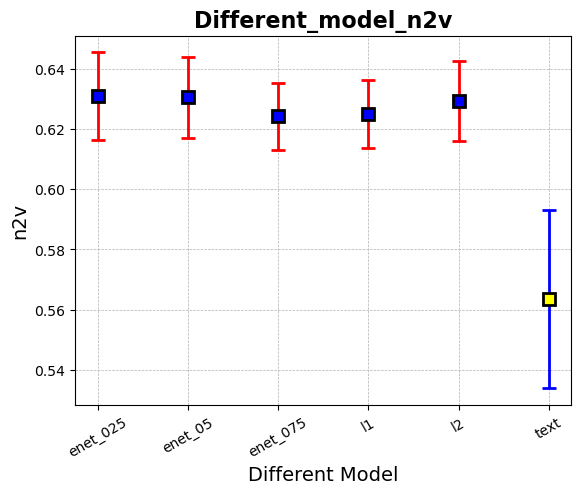

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


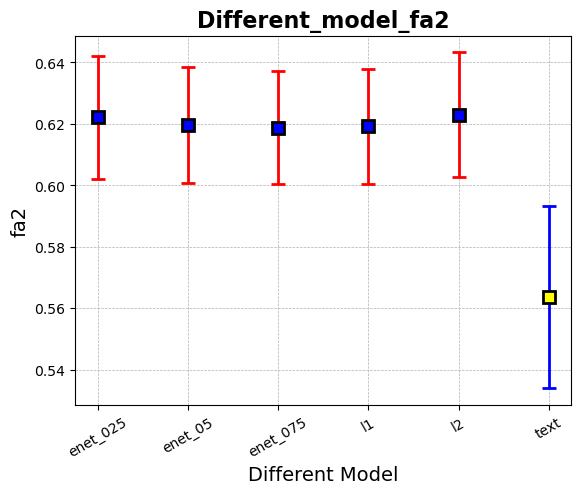

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


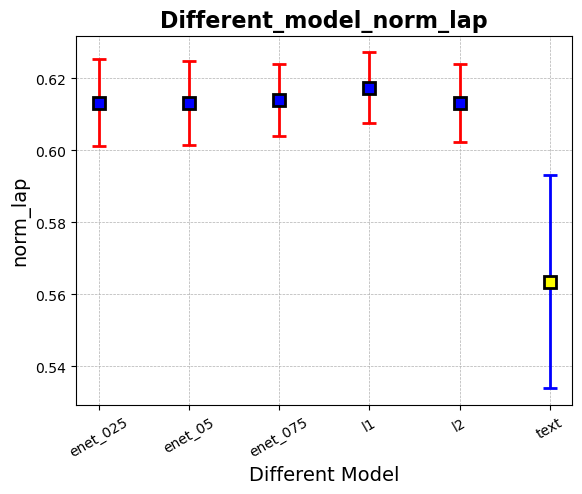

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


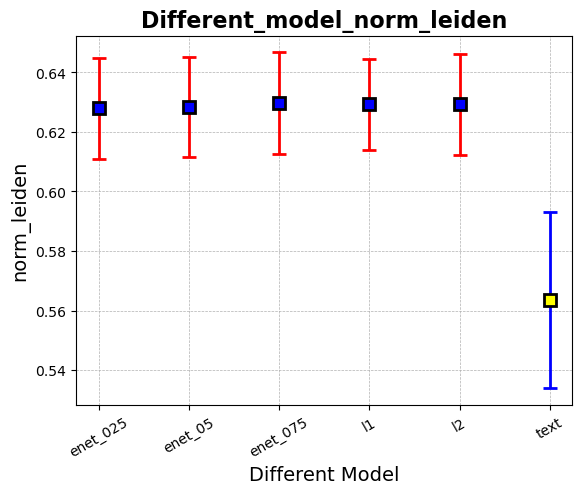

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


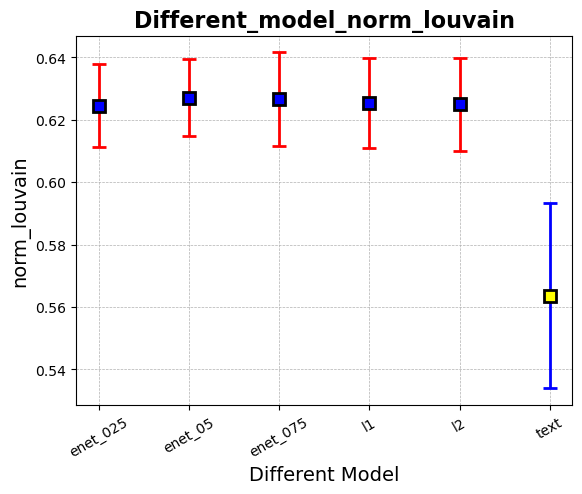

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


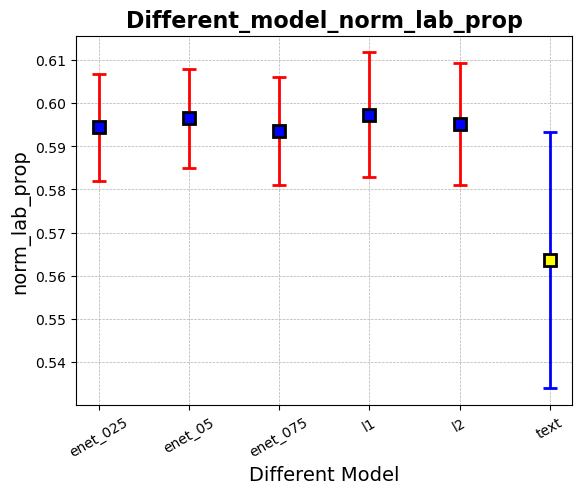

In [31]:
for i in table_1.index:
    plotting(models,table_1[models].loc[i].to_list(),(test_df["text"].loc["accuracy"],test_error_df["text"].loc["accuracy"]),y_errs=err_table_1[models].loc[i].to_list(),x_axis='Different Model',y_axis=i,name=f"Different_model_{i}",WORKING_PATH="/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/tables/plots/different_model/")

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


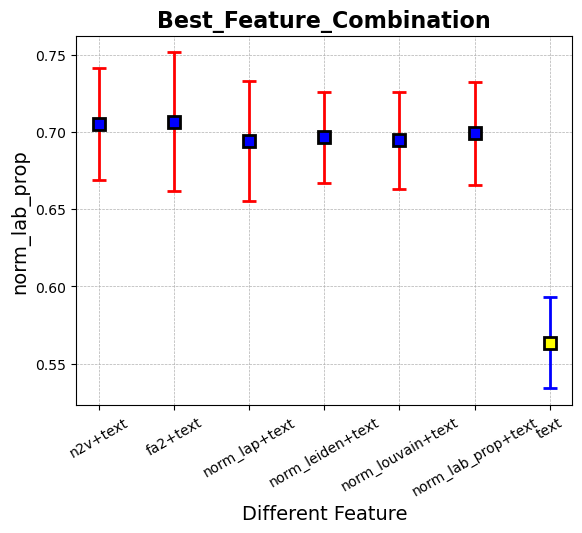

In [32]:
plotting(second_table_df.columns,second_table_df.loc["accuracy"].to_list(),(test_df["text"].loc["accuracy"],test_error_df["text"].loc["accuracy"]),y_errs=second_table_df_err.loc["accuracy"].to_list(),x_axis='Different Feature',y_axis=i,name=f"Best_Feature_Combination",WORKING_PATH="/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/tables/plots/best_feature_comb/")

In [33]:
comps=[i for i in test_df.columns if i!="text" ]
comps

['n2v',
 'fa2',
 'norm_lap',
 'norm_leiden',
 'norm_louvain',
 'norm_lab_prop',
 'fa2+text']

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


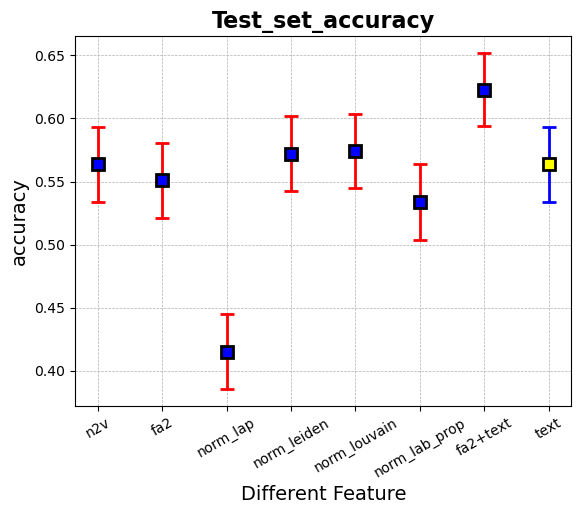

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


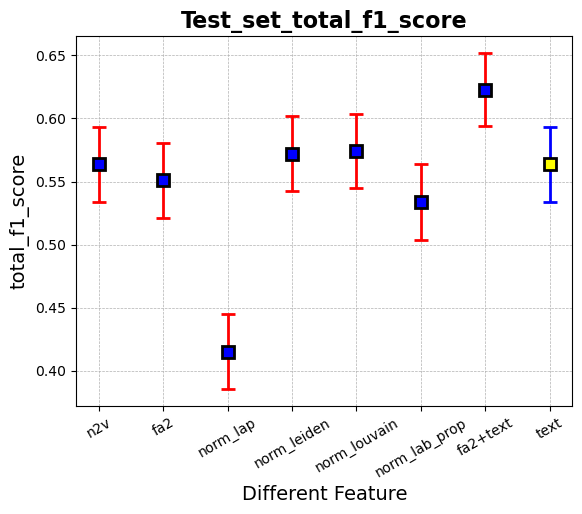

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


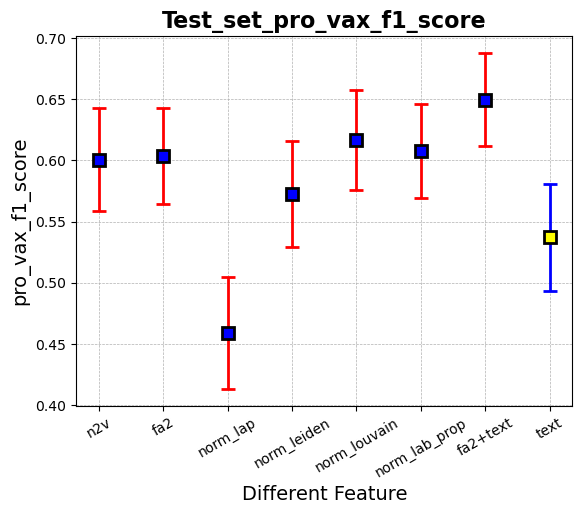

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


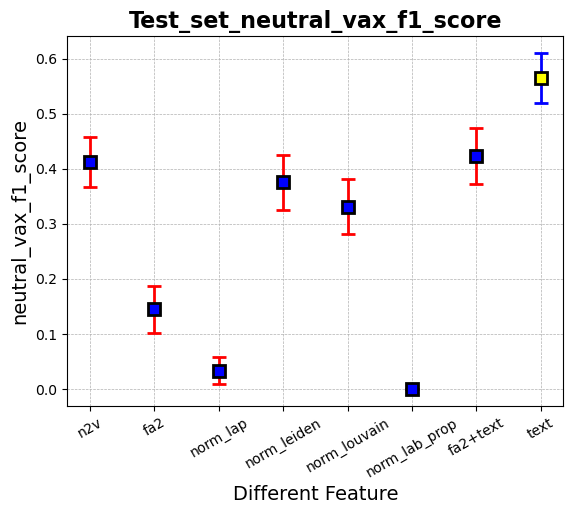

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


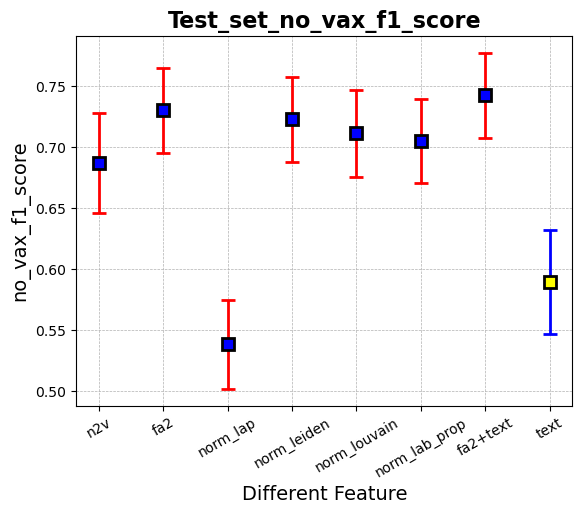

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


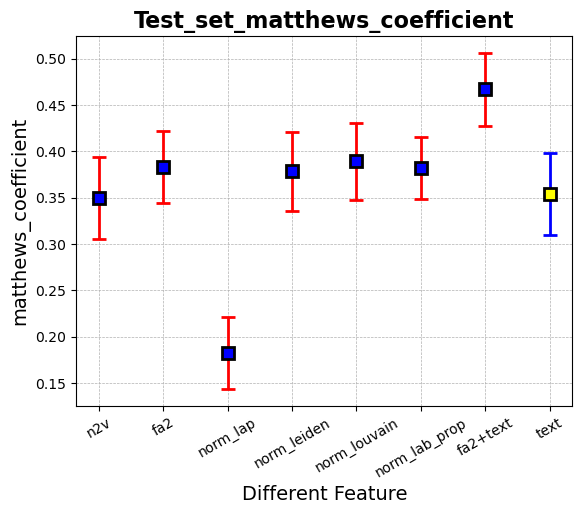

In [34]:
for i in test_df.index:
    plotting(comps,test_df[comps].loc[i].to_list(),(test_df["text"].loc[i],test_error_df["text"].loc[i]),y_errs=test_error_df[comps].loc[i].to_list(),x_axis='Different Feature',y_axis=i,name=f"Test_set_{i}",WORKING_PATH="/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/tables/plots/test/")

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


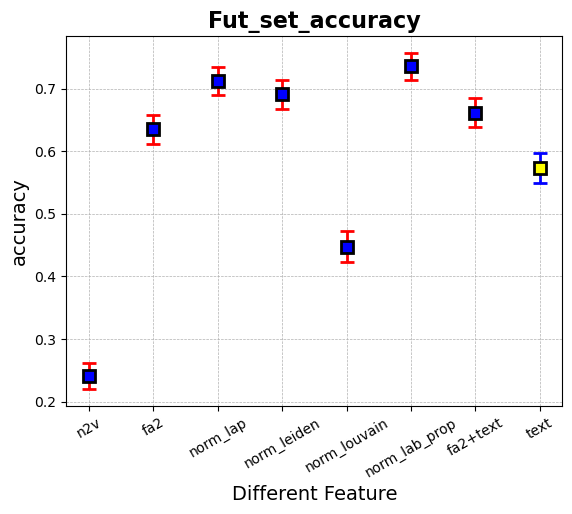

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


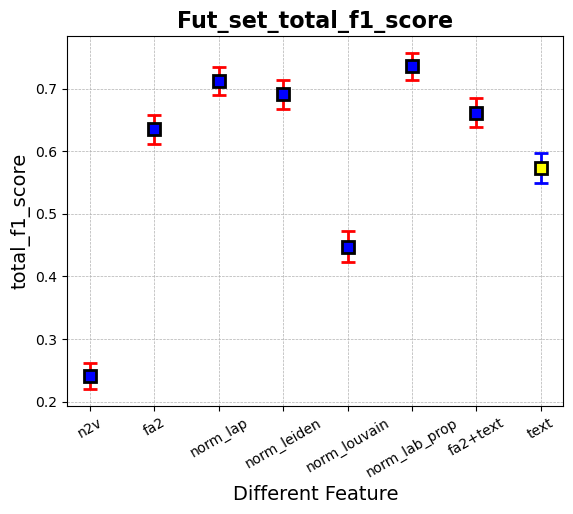

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


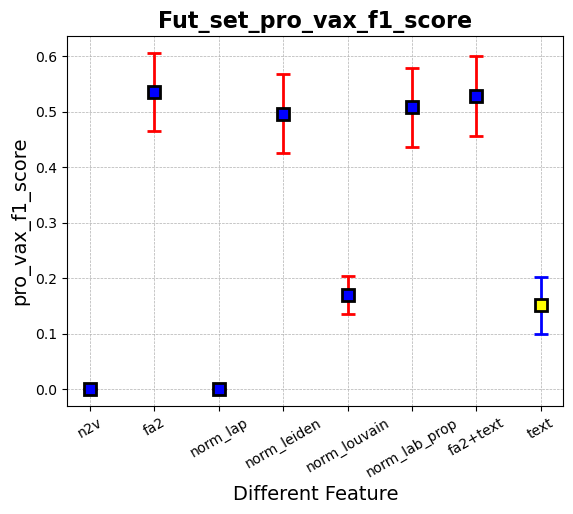

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


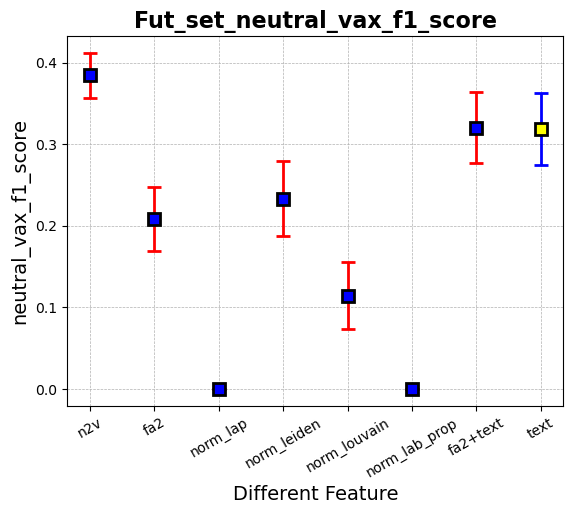

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


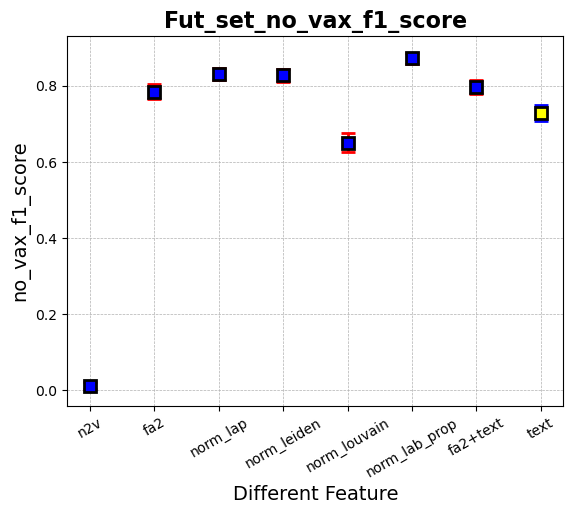

/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=y_errs, fmt='o', ecolor='red', capsize=5, capthick=2, elinewidth=2,
/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/plotting.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(["text"], text_val, yerr=np.array(text_err).T, fmt='o', ecolor='blue', capsize=5, capthick=2, elinewidth=2,


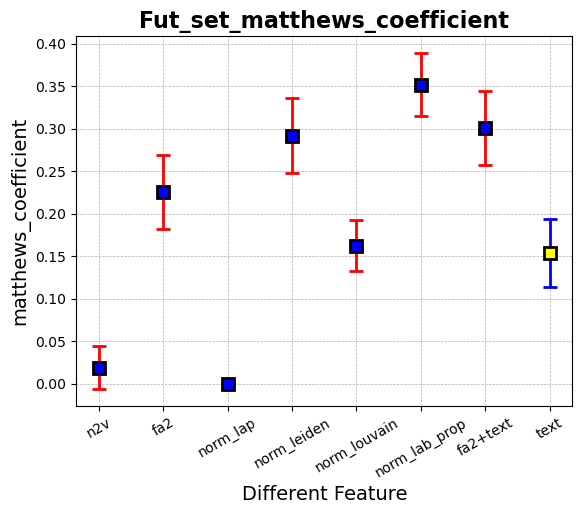

In [35]:
for i in fut_df.index:
    plotting(comps,fut_df[comps].loc[i].to_list(),(fut_df["text"].loc[i],fut_error_df["text"].loc[i]),y_errs=fut_error_df[comps].loc[i].to_list(),x_axis='Different Feature',y_axis=i,name=f"Fut_set_{i}",WORKING_PATH="/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/tables/plots/fut/")

In [36]:
from plotting import multi_plot
import matplotlib.pyplot as plt

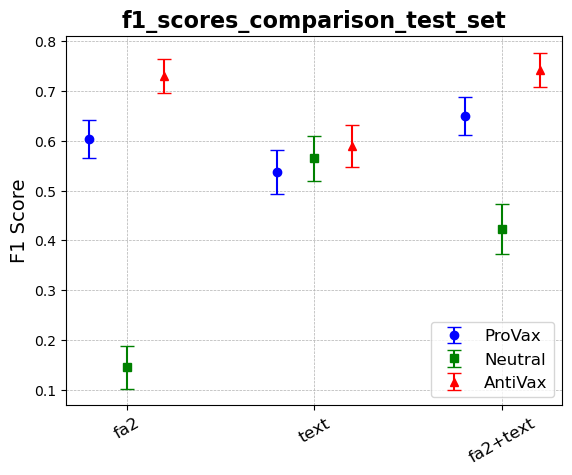

In [37]:
x_labels = ["fa2", "text", "fa2+text"]
targets=["pro_vax_f1_score","neutral_vax_f1_score","no_vax_f1_score"]
values=[[test_df[i].loc[j] for j in targets] for i in x_labels]
errors=[[test_error_df[i].loc[j] for j in targets] for i in x_labels]
multi_plot(x_labels, values, errors, name="f1_scores_comparison_test_set",WORKING_PATH="/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/tables/plots/f1_comp/")

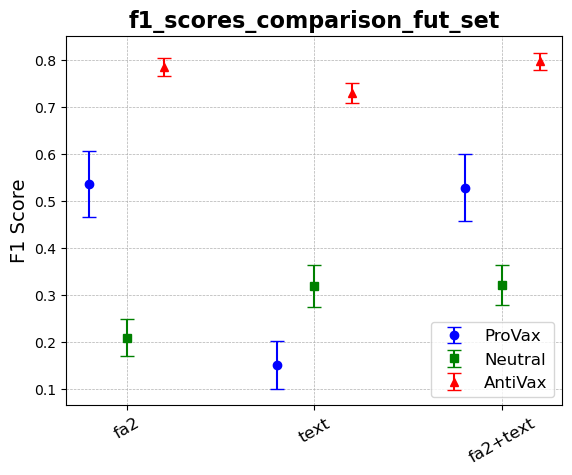

In [38]:
x_labels = ["fa2", "text", "fa2+text"]
targets=["pro_vax_f1_score","neutral_vax_f1_score","no_vax_f1_score"]
values=[[fut_df[i].loc[j] for j in targets] for i in x_labels]
errors=[[fut_error_df[i].loc[j] for j in targets] for i in x_labels]
multi_plot(x_labels, values, errors, name="f1_scores_comparison_fut_set",WORKING_PATH="/home/PERSONALE/niccolo.barbieri3/TwitterVaccine/tables/plots/f1_comp/")